# Minimal Robust Positively Invariant Set

### Introduction

In this example, we implement the method presented in [RKKM05] to compute a robust positively invariant polytope of a linear system under a disturbance bounded by a polytopic set.

We consider the example given in equation (15) of [RKKM05]:
$$
x^+ =
\begin{bmatrix}
  1 & 1\\
  0 & 1
\end{bmatrix}x +
\begin{bmatrix}
  1\\
  1
\end{bmatrix} u
+ w
$$
with the state feedback control $u(x) = -\begin{bmatrix}1.17 & 1.03\end{bmatrix} x$.
The controlled system is therefore
$$
x^+ =
\left(\begin{bmatrix}
  1 & 1\\
  0 & 1
\end{bmatrix} -
\begin{bmatrix}
  1\\
  1
\end{bmatrix}
\begin{bmatrix}1.17 & 1.03\end{bmatrix}\right)x
+ w =
\begin{bmatrix}
  -0.17 & -0.03\\
  -1.17 & -0.03
\end{bmatrix}x
+ w.
$$

[RKKM05] Sasa V. Rakovic, Eric C. Kerrigan, Konstantinos I. Kouramas, David Q. Mayne *Invariant approximations of the minimal robust positively Invariant set*. IEEE Transactions on Automatic Control 50 (**2005**): 406-410.

In [1]:
A = [1 1; 0 1] - [1; 1] * [1.17 1.03]

2×2 Array{Float64,2}:
 -0.17  -0.03
 -1.17  -0.03

The set of disturbance is the unit ball of the infinity norm.

In [2]:
using Polyhedra
Wv = vrep([[x, y] for x in [-1.0, 1.0] for y in [-1.0, 1.0]])

V-representation Polyhedra.PointsHull{Float64,Array{Float64,1},Int64}:
4-element iterator of Array{Float64,1}:
 [-1.0, -1.0]
 [-1.0, 1.0]
 [1.0, -1.0]
 [1.0, 1.0]

We will use the default library for this example but feel free to pick any other library from [this list of available libraries](https://juliapolyhedra.github.io/) such as [CDDLib](https://github.com/JuliaPolyhedra/CDDLib.jl).
The LP solver used to detect redundant points in the V-representation is [GLPK](https://github.com/JuliaOpt/GLPK.jl). Again, you can replace it with any other solver listed [here](http://jump.dev/JuMP.jl/dev/installation/#Getting-Solvers-1) that supports LP.

In [3]:
using GLPK
using JuMP
lib = DefaultLibrary{Float64}(GLPK.Optimizer)
W = polyhedron(Wv, lib)

Polyhedron DefaultPolyhedron{Float64,Polyhedra.Intersection{Float64,Array{Float64,1},Int64},Polyhedra.Hull{Float64,Array{Float64,1},Int64}}:
4-element iterator of Array{Float64,1}:
 [-1.0, -1.0]
 [-1.0, 1.0]
 [1.0, -1.0]
 [1.0, 1.0]

The $F_s$ function of equation (2) of [RKKM05] can be implemented as follows.

In [4]:
function Fs(s::Integer, verbose=1)
    @assert s ≥ 1
    F = W
    A_W = W
    for i in 1:(s-1)
        A_W = A * A_W
        F += A_W
        if verbose ≥ 1
            println("Number of points after adding A^$i * W: ", npoints(F))
        end
        removevredundancy!(F)
        if verbose ≥ 1
            println("Number of points after removing redundant ones: ", npoints(F))
        end
    end
    return F
end

Fs (generic function with 2 methods)

We can see below that only the V-representation is computed. In fact, no H-representation was ever computed during `Fs`. Computing $AW$ is done by multiplying all the points by $A$ and doing the Minkowski sum is done by summing each pair of points. The redundancy removal is carried out by CDD's internal LP solver.

In [5]:
@time Fs(4)

Number of points after adding A^1 * W: 16
Number of points after removing redundant ones: 8
Number of points after adding A^2 * W: 32
Number of points after removing redundant ones: 12
Number of points after adding A^3 * W: 48
Number of points after removing redundant ones: 16
  4.766862 seconds (16.49 M allocations: 918.227 MiB, 11.23% gc time)


Polyhedron DefaultPolyhedron{Float64,Polyhedra.Intersection{Float64,Array{Float64,1},Int64},Polyhedra.Hull{Float64,Array{Float64,1},Int64}}:
16-element iterator of Array{Float64,1}:
 [-1.29, -2.56]
 [-1.29, -0.56]
 [-0.95, 1.78]
 [-0.938, 1.852]
 [-0.9022, 2.0158]
 [-0.898, 2.032]
 [-0.77, 2.5]
 [-0.71, 2.56]
 [1.29, 2.56]
 [1.29, 0.56]
 [0.95, -1.78]
 [0.938, -1.852]
 [0.9022, -2.0158]
 [0.898, -2.032]
 [0.77, -2.5]
 [0.71, -2.56]

The Figure 1 of [RKKM05] can be reproduced as follows:

In [6]:
using Plots
plot()
for i in 10:-1:1
    plot!(Fs(i, 0))
end

The cell needs to return the plot for it to be displayed
but the `for` loop returns `nothing` so we add this dummy `plot!` that returns the plot

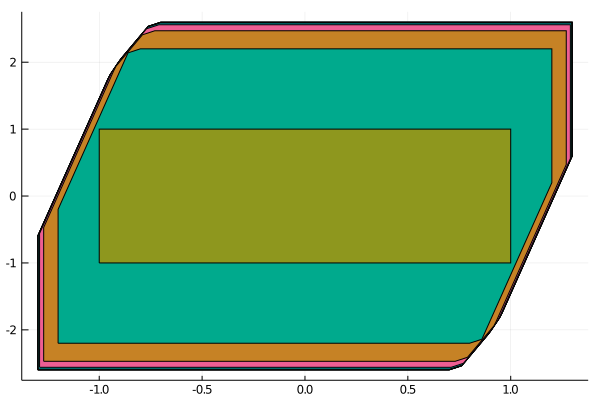

In [7]:
plot!()

Now, suppose we want to compute an invariant set by scaling $F_s$ by the appropriate $\alpha$.
In equation (11) of [RKKM05], we want to check whether $A^s W \subseteq \alpha W$ which is equivalent to $W \subseteq \alpha A^{-s} W$.
Note that `A^s \ W` triggers the computation of the H-representation of `W` and `A_W` is H-represented.

In [8]:
function αo(s)
    A_W = A^s \ W
    hashyperplanes(A_W) && error("HyperPlanes not supported")
    return maximum([Polyhedra.support_function(h.a, W) / h.β for h in halfspaces(A_W)])
end

αo (generic function with 1 method)

We obtain $\alpha \approx 1.9 \cdot 10^{-5}$ like in [RKKM05].

In [9]:
α = αo(10)

1.9190700000000013e-5

The scaled set is is the following:

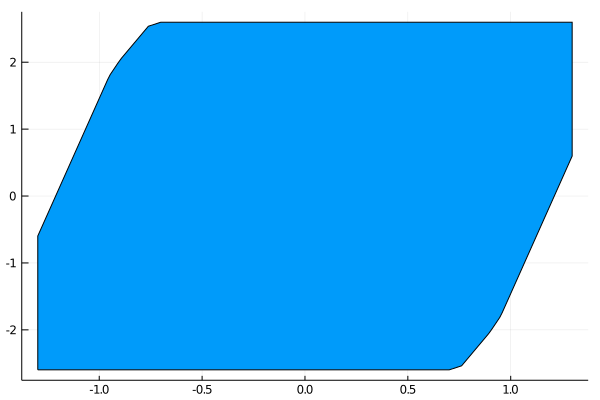

In [10]:
using Plots
plot((1 - α)^(-1) * Fs(10, 0))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*